In [2]:
import numpy as np
import yfinance as yf
import pandas as pd
# import talib as ta
import tulipy as ti
from math import asin, sqrt
import matplotlib.pyplot as plt
# from termcolor import colored as cl
from math import floor
from fredapi import Fred
import investpy
import seaborn as sns
import itertools
from qiskit_aer import AerSimulator
from qiskit.providers.basic_provider import BasicProvider
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import ZZFeatureMap, ZFeatureMap
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler, Options
# from qiskit_ibm_runtime import SamplerV2 as Sampler
from pgmpy.models import BayesianModel,BayesianNetwork
from pgmpy.base import DAG
from pgmpy.factors.discrete import TabularCPD
from pgmpy.estimators import BayesianEstimator, MaximumLikelihoodEstimator
from pgmpy.estimators import BicScore, K2Score#, BdeuScore
from pgmpy.estimators import HillClimbSearch
import networkx as nx
import pylab as plt
import warnings
import logging

In [3]:
# import logging
# logging.getLogger('qiskit_ibm_runtime').setLevel(logging.WARNING)

In [4]:
QiskitRuntimeService.save_account(channel = 'ibm_quantum',
                                  token = 'afbbd92eae66abcc98ea8bfd6269888a2fbeb2cc875b1f30c6cc67ced46d4b5ef84270be2de6c64361ec83180dd3f6f1c616db0debf34cdf5d7816ba9d374597',
                                  instance='ibm-q/open/main',
                                  overwrite=True)
service = QiskitRuntimeService(verify=False)

/home/aniruddha/miniconda3/envs/capstone_env/lib/python3.10/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'auth.quantum-computing.ibm.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/aniruddha/miniconda3/envs/capstone_env/lib/python3.10/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'auth.quantum-computing.ibm.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/aniruddha/miniconda3/envs/capstone_env/lib/python3.10/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'auth.quantum-computing.ibm.com'. Adding certificate verification is strongly advised. See: https://url

In [5]:
#### semiconductor, aluminium, plastic, copper, oil
#### USD, Yuan,

In [6]:
start_date = '2019-01-01'
end_date = '2019-12-31'

In [7]:
data0 = yf.download("AAPL", start=start_date, end=end_date)['Adj Close']
data0.head()

[*********************100%%**********************]  1 of 1 completed


Date
2019-01-02    37.793777
2019-01-03    34.029247
2019-01-04    35.481922
2019-01-07    35.402950
2019-01-08    36.077839
Name: Adj Close, dtype: float64

In [8]:
# ^SOX > PHLX semiconductor data
# CNY=X > Yuan to USD forex rate
# EUR=X > EURO to USD forex rate
# ^TNX > CBOE Interest Rate 10 Year T No

data1 = yf.download(["^SOX","CNY=X","EUR=X","^TNX"], start=start_date, end=end_date)['Adj Close']
data1.head()

[*********************100%%**********************]  4 of 4 completed


Ticker,CNY=X,EUR=X,^SOX,^TNX
Date,,,,
2019-01-01,6.8776,0.87009,NaN,NaN
2019-01-02,6.8775,0.87247,1165.300049,2.661
2019-01-03,6.8611,0.88354,1096.030029,2.554
2019-01-04,6.8711,0.87788,1143.959961,2.659
2019-01-07,6.8684,0.87639,1166.239990,2.682


In [9]:
# Replace 'YOUR_API_KEY' with your actual FRED API key
fred = Fred(api_key='8bd22ac3ad2b9cdcbe7c4d5bb66e94ae')

# 'DCOILWTICO' > West Texas Intermediate (WTI) - Cushing, Oklahoma - crude oil
# DFF' > Federal fund rate


# Define a list of series IDs
series_ids = ['DFF','DCOILWTICO']

# Initialize an empty DataFrame to store the data
data2 = pd.DataFrame()

# Loop through each series ID and fetch the data
for series_id in series_ids:
    df = fred.get_series(series_id)
    data2[series_id] = df

# Filter the DataFrame to include data only from 2010 to 2020
data2 = data2.loc[data0.index]
data2.head()

,DFF,DCOILWTICO
Date,,
2019-01-02,2.4,46.31
2019-01-03,2.4,46.92
2019-01-04,2.4,47.76
2019-01-07,2.4,48.27
2019-01-08,2.4,49.58


In [10]:
data3 = yf.download(["^VIX","^NDX","^GSPC"], start=start_date, end=end_date)['Adj Close']
data3.head()

[*********************100%%**********************]  3 of 3 completed


Ticker,^GSPC,^NDX,^VIX
Date,,,
2019-01-02,2510.030029,6360.870117,23.219999
2019-01-03,2447.889893,6147.129883,25.450001
2019-01-04,2531.939941,6422.669922,21.379999
2019-01-07,2549.689941,6488.250000,21.400000
2019-01-08,2574.409912,6551.850098,20.469999


In [11]:
df = pd.concat([data0,data1,data2,data3],axis=1)
df.head()

,Adj Close,CNY=X,EUR=X,^SOX,^TNX,DFF,DCOILWTICO,^GSPC,^NDX,^VIX
Date,,,,,,,,,,
2019-01-01,NaN,6.8776,0.87009,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-02,37.793777,6.8775,0.87247,1165.300049,2.661,2.4,46.31,2510.030029,6360.870117,23.219999
2019-01-03,34.029247,6.8611,0.88354,1096.030029,2.554,2.4,46.92,2447.889893,6147.129883,25.450001
2019-01-04,35.481922,6.8711,0.87788,1143.959961,2.659,2.4,47.76,2531.939941,6422.669922,21.379999
2019-01-07,35.402950,6.8684,0.87639,1166.239990,2.682,2.4,48.27,2549.689941,6488.250000,21.400000


In [12]:
df.isna().sum()

Adj Close      9
CNY=X          2
EUR=X          1
^SOX           9
^TNX           9
DFF            9
DCOILWTICO    11
^GSPC          9
^NDX           9
^VIX           9
dtype: int64

In [13]:
df = df.dropna()
df.isna().sum()

Adj Close     0
CNY=X         0
EUR=X         0
^SOX          0
^TNX          0
DFF           0
DCOILWTICO    0
^GSPC         0
^NDX          0
^VIX          0
dtype: int64

In [14]:
df.head()

,Adj Close,CNY=X,EUR=X,^SOX,^TNX,DFF,DCOILWTICO,^GSPC,^NDX,^VIX
Date,,,,,,,,,,
2019-01-02,37.793777,6.8775,0.87247,1165.300049,2.661,2.4,46.31,2510.030029,6360.870117,23.219999
2019-01-03,34.029247,6.8611,0.88354,1096.030029,2.554,2.4,46.92,2447.889893,6147.129883,25.450001
2019-01-04,35.481922,6.8711,0.87788,1143.959961,2.659,2.4,47.76,2531.939941,6422.669922,21.379999
2019-01-07,35.402950,6.8684,0.87639,1166.239990,2.682,2.4,48.27,2549.689941,6488.250000,21.400000
2019-01-08,36.077839,6.8500,0.87110,1160.550049,2.716,2.4,49.58,2574.409912,6551.850098,20.469999


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 247 entries, 2019-01-02 to 2019-12-30
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Adj Close   247 non-null    float64
 1   CNY=X       247 non-null    float64
 2   EUR=X       247 non-null    float64
 3   ^SOX        247 non-null    float64
 4   ^TNX        247 non-null    float64
 5   DFF         247 non-null    float64
 6   DCOILWTICO  247 non-null    float64
 7   ^GSPC       247 non-null    float64
 8   ^NDX        247 non-null    float64
 9   ^VIX        247 non-null    float64
dtypes: float64(10)
memory usage: 21.2 KB


In [16]:
data = df.pct_change().dropna()
data.head()


,Adj Close,CNY=X,EUR=X,^SOX,^TNX,DFF,DCOILWTICO,^GSPC,^NDX,^VIX
Date,,,,,,,,,,
2019-01-03,-0.099607,-0.002385,0.012688,-0.059444,-0.040210,0.0,0.013172,-0.024757,-0.033602,0.096038
2019-01-04,0.042689,0.001457,-0.006406,0.043730,0.041112,0.0,0.017903,0.034336,0.044824,-0.159921
2019-01-07,-0.002226,-0.000393,-0.001697,0.019476,0.008650,0.0,0.010678,0.007010,0.010211,0.000935
2019-01-08,0.019063,-0.002679,-0.006036,-0.004879,0.012677,0.0,0.027139,0.009695,0.009802,-0.043458
2019-01-09,0.016982,0.000321,0.002066,0.025238,0.004418,0.0,0.052642,0.004098,0.007454,-0.023937


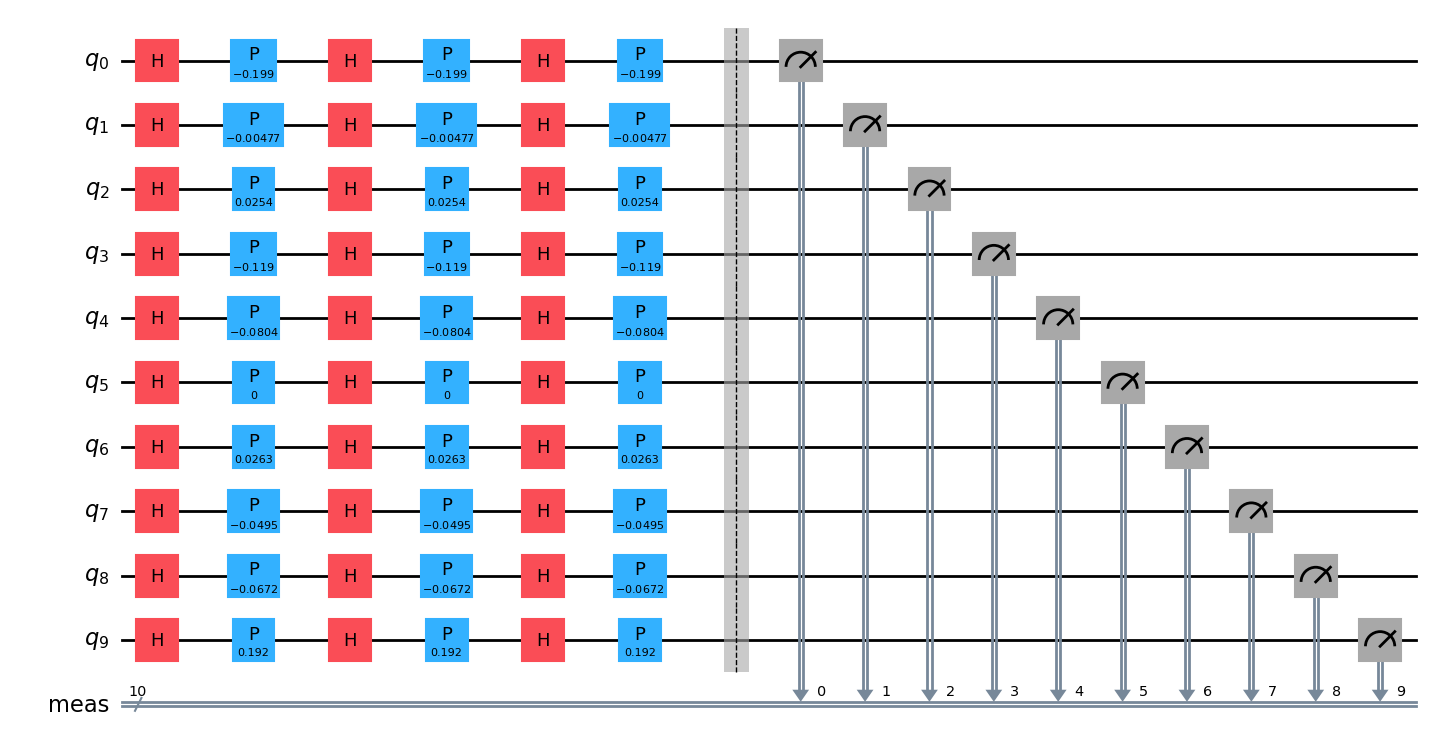

In [17]:
quantum_map = ZFeatureMap(data.shape[1], reps=3)
warnings.filterwarnings("ignore")

encode_circuit = quantum_map.assign_parameters(data.iloc[0])
encode_circuit.measure_all()
encode_circuit.decompose().draw('mpl',fold=60)

In [18]:
data_dist = []
new_data = []

backend = AerSimulator() #BasicProvider().get_backend('basic_simulator')

for i in range(data.shape[0]):
    quantum_map = ZFeatureMap(data.shape[1], reps=3)
    encoder_circuit = quantum_map.assign_parameters(data.iloc[i])
    encoder_circuit.measure_all()


    pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
    isa_circuit = pm.run(encode_circuit)

    with Session(service, backend = backend) as session:
        sampler = Sampler(session=session)
    
        job = sampler.run(encoder_circuit, shots=100)
        binary_data = job.result().quasi_dists[0].binary_probabilities()
        binary_data = max(zip(binary_data.values(), binary_data.keys()))[1]
        # print(f"Job ID: {job.job_id()} --------{binary_data}")
        # data_dist.append(list(binary_data.keys())[0])
        new_data.append([int(i) for i in binary_data])
        # print(f"Job result: {job.result()}")

INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01216 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.01597 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01454 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 5.82075 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('p', 1), ('h', 1), ('measure', 1), ('barrier', 10)} to target basis {'mcu1', 'r', 'cu1', 'delay', 'diagonal', 'cu3', 'mcx_gray', 'unitary', 'save_probabilities', 'rxx', 'y', 'x', 'initialize', 'cx', 'u2', 'mcu2', 'ccx', 'for_loop', 'h', 'mcphase', 'multiplexer', 'save_expval', 's', 'save_state', 'snapshot', 'sx', 'tdg', 'u', 'if_else', 'store', 'mcr', 'measure', 'cu', 'rzz', 'mcsx', 'cz', 'mcrz', 'pauli', 'quantum_channel', 'rzx', 'break_loop', 'ry', 'cy', 'mcswap', 'set_stabilizer', 'mcu3', 'ecr', 'z', 'rz', 'mcrx', 'save_stabilizer', 'id', 'mcp', 'mcx', 'cu2', 'sxdg', 'barrier', 'superop', 'u1', 

In [19]:
new_data = pd.DataFrame(np.array(new_data),columns=data.columns)
new_data.head()

,Adj Close,CNY=X,EUR=X,^SOX,^TNX,DFF,DCOILWTICO,^GSPC,^NDX,^VIX
0,1,1,1,1,1,0,1,1,1,0
1,1,1,1,1,0,0,1,1,1,0
2,1,1,1,0,0,0,1,0,0,1
3,1,1,0,1,0,1,1,1,1,1
4,1,1,1,0,1,1,0,1,0,0


In [20]:
for col in new_data.columns:
    print(new_data[col].value_counts())

Adj Close
1    209
0     37
Name: count, dtype: int64
CNY=X
1    173
0     73
Name: count, dtype: int64
EUR=X
1    150
0     96
Name: count, dtype: int64
^SOX
1    139
0    107
Name: count, dtype: int64
^TNX
0    128
1    118
Name: count, dtype: int64
DFF
0    123
1    123
Name: count, dtype: int64
DCOILWTICO
0    130
1    116
Name: count, dtype: int64
^GSPC
0    129
1    117
Name: count, dtype: int64
^NDX
1    132
0    114
Name: count, dtype: int64
^VIX
0    129
1    117
Name: count, dtype: int64


In [21]:
new_data['Adj Close'] = data['Adj Close'].apply(lambda x: 0 if x <= 0 else 1).values
new_data.head()

,Adj Close,CNY=X,EUR=X,^SOX,^TNX,DFF,DCOILWTICO,^GSPC,^NDX,^VIX
0,0,1,1,1,1,0,1,1,1,0
1,1,1,1,1,0,0,1,1,1,0
2,0,1,1,0,0,0,1,0,0,1
3,1,1,0,1,0,1,1,1,1,1
4,1,1,1,0,1,1,0,1,0,0


In [22]:
new_data['forecast'] = new_data['Adj Close'].shift(1)
new_data.head()

,Adj Close,CNY=X,EUR=X,^SOX,^TNX,DFF,DCOILWTICO,^GSPC,^NDX,^VIX,forecast
0,0,1,1,1,1,0,1,1,1,0,NaN
1,1,1,1,1,0,0,1,1,1,0,0.0
2,0,1,1,0,0,0,1,0,0,1,1.0
3,1,1,0,1,0,1,1,1,1,1,0.0
4,1,1,1,0,1,1,0,1,0,0,1.0


In [23]:
new_data = new_data.dropna()
new_data.head()

,Adj Close,CNY=X,EUR=X,^SOX,^TNX,DFF,DCOILWTICO,^GSPC,^NDX,^VIX,forecast
1,1,1,1,1,0,0,1,1,1,0,0.0
2,0,1,1,0,0,0,1,0,0,1,1.0
3,1,1,0,1,0,1,1,1,1,1,0.0
4,1,1,1,0,1,1,0,1,0,0,1.0
5,1,1,0,0,0,0,0,1,0,1,1.0


In [24]:
new_data = new_data.apply(np.int64)
new_data.head()

,Adj Close,CNY=X,EUR=X,^SOX,^TNX,DFF,DCOILWTICO,^GSPC,^NDX,^VIX,forecast
1,1,1,1,1,0,0,1,1,1,0,0
2,0,1,1,0,0,0,1,0,0,1,1
3,1,1,0,1,0,1,1,1,1,1,0
4,1,1,1,0,1,1,0,1,0,0,1
5,1,1,0,0,0,0,0,1,0,1,1


In [25]:
new_data.columns

Index(['Adj Close', 'CNY=X', 'EUR=X', '^SOX', '^TNX', 'DFF', 'DCOILWTICO',
       '^GSPC', '^NDX', '^VIX', 'forecast'],
      dtype='object')

In [26]:
my_edges = []
for col in new_data.columns[:-1]:
    my_edges.append((col,'forecast'))

my_edges

[('Adj Close', 'forecast'),
 ('CNY=X', 'forecast'),
 ('EUR=X', 'forecast'),
 ('^SOX', 'forecast'),
 ('^TNX', 'forecast'),
 ('DFF', 'forecast'),
 ('DCOILWTICO', 'forecast'),
 ('^GSPC', 'forecast'),
 ('^NDX', 'forecast'),
 ('^VIX', 'forecast')]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Learned bayesian structure edges are:
 [('Adj Close', 'forecast'), ('CNY=X', 'forecast'), ('CNY=X', 'EUR=X'), ('EUR=X', 'forecast'), ('^SOX', 'forecast'), ('^SOX', 'DFF'), ('^TNX', 'forecast'), ('DFF', 'forecast'), ('^GSPC', 'forecast'), ('^NDX', 'forecast'), ('^VIX', 'forecast')]


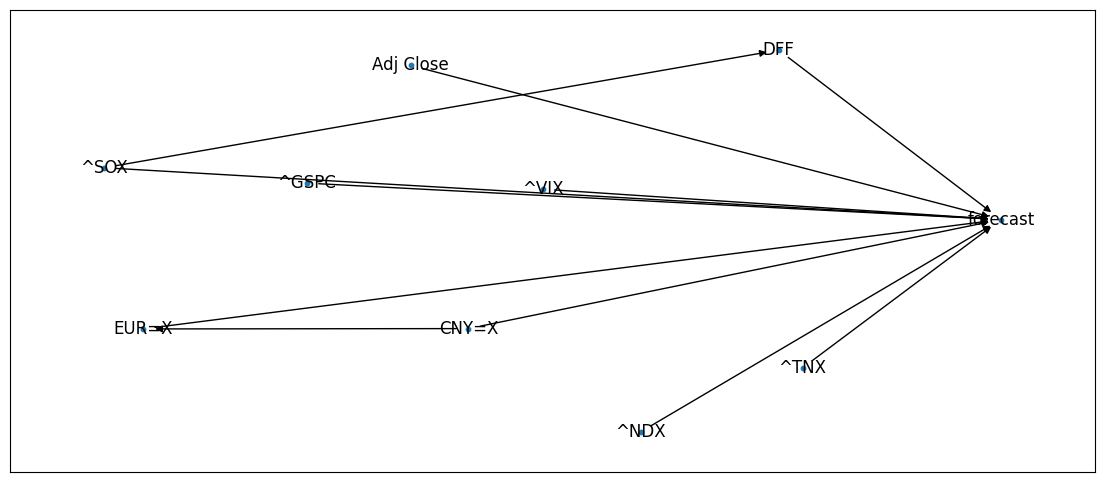

In [27]:
############ appliying hillclimb search for finding best bayesian network ############
################## if some prior structure is known ########################
edges = my_edges
# [
#          ('CNY=X','^GSPC'),('^VIX','DFF'),('^VIX','^GSPC'),
#          ('^GSPC','^NDX'),('DFF','^NDX'),('^NDX','forecast'),('^SOX','forecast')
#         ]

train_df = new_data.iloc[:,:]
model = BayesianNetwork()
model.add_nodes_from(nodes=list(train_df.columns))
model.add_edges_from(edges)

hc = HillClimbSearch(train_df,state_names=dict(map(lambda e: (e, [0, 1]), train_df),node_names=list(train_df.columns)))

k2 = K2Score(train_df)
learned_model = hc.estimate(start_dag=model,scoring_method=k2)

print("Learned bayesian structure edges are:\n",learned_model.edges())

##### Fitting the Data into Learned Model ###############
learned_model.fit(train_df,state_names=dict(map(lambda e: (e, [0, 1]), train_df.columns)),
                  estimator=BayesianEstimator, prior_type="K2");

######## Drawing the network ######################
plt.figure(figsize=(14,6))
G=nx.DiGraph();
G.add_edges_from(learned_model.edges());
label_dict = {}
for node in G.nodes():
    label_dict[node] = node
pos = nx.spring_layout(G);
nx.draw_networkx_nodes(G, pos, node_size = 10);
nx.draw_networkx_edges(G, pos, arrows=True);
nx.draw_networkx_labels(G,pos,labels=label_dict,)
plt.show()

In [28]:
print('Nodes of the model:',learned_model.nodes())
print('Edges of the model:',learned_model.edges())

#### Printing CPD table of the dataset ###########
for model in learned_model.get_cpds():
    print("\n\nThe CPD table is:\n",model)


Nodes of the model: ['Adj Close', 'CNY=X', 'EUR=X', '^SOX', '^TNX', 'DFF', 'DCOILWTICO', '^GSPC', '^NDX', '^VIX', 'forecast']
Edges of the model: [('Adj Close', 'forecast'), ('CNY=X', 'forecast'), ('CNY=X', 'EUR=X'), ('EUR=X', 'forecast'), ('^SOX', 'forecast'), ('^SOX', 'DFF'), ('^TNX', 'forecast'), ('DFF', 'forecast'), ('^GSPC', 'forecast'), ('^NDX', 'forecast'), ('^VIX', 'forecast')]


The CPD table is:
 +--------------+----------+
| Adj Close(0) | 0.412955 |
+--------------+----------+
| Adj Close(1) | 0.587045 |
+--------------+----------+


The CPD table is:
 +----------+----------+
| CNY=X(0) | 0.299595 |
+----------+----------+
| CNY=X(1) | 0.700405 |
+----------+----------+


The CPD table is:
 +----------+----------+--------------------+
| CNY=X    | CNY=X(0) | CNY=X(1)           |
+----------+----------+--------------------+
| EUR=X(0) | 0.52     | 0.3390804597701149 |
+----------+----------+--------------------+
| EUR=X(1) | 0.48     | 0.6609195402298851 |
+----------+------

In [29]:

def prob_to_angle(prob):
    return 2*asin(sqrt(prob))

def custom_mcry(circuit,angle,control_qubits,target,control_state):
	Id = []
	for i in range(len(control_state)):
		c = control_state[i]
		if c == '0':
			Id.append(control_qubits[i])			
		else:
			pass
	if len(Id) == 0:
		pass
	else:
		circuit.x(Id)
	circuit.mcry(angle,control_qubits,target)
	if len(Id) == 0:
		pass
	else:
		circuit.x(Id)
	return circuit

In [30]:
node_list = list(learned_model.nodes())
cr = ClassicalRegister(1,'signal')
qc= QuantumCircuit([],cr)

for node in node_list:
    qc.add_register(QuantumRegister(1,node)) # Adding qubits with names same as nodes
# qc.draw('mpl')

In [31]:
for i in range(len(learned_model.get_cpds())):
    my_model = learned_model.get_cpds()[i]
    print('\n\nModel state space:',my_model.state_names)

    if len(my_model.variables) == 1:
        cpd = pd.DataFrame(my_model.get_values(),columns=['Probs']).rename_axis(my_model.variable,axis=1)
        cpd['theta'] = 2*np.arctan(np.sqrt(cpd['Probs'].iloc[0]/cpd['Probs'].iloc[1]))
        print(cpd)

        qc.ry(prob_to_angle(my_model.values[1]),node_list.index(my_model.variable))
    else:
        print('Control:',my_model.variables[1:],'-----------> Target:',my_model.variable)

        lst = np.array(list(itertools.product([0, 1], repeat=len(my_model.variables)-1)))
        cpd = pd.DataFrame(np.array(lst),columns = my_model.variables[1:])
        cpd['Prob_'+ my_model.variable + str(0)] = my_model.get_values()[0,:]
        cpd['Prob_'+ my_model.variable + str(1)] = my_model.get_values()[1,:]
        cpd['theta'] = 2*np.arctan(np.sqrt(cpd['Prob_'+ my_model.variable + str(0)]/cpd['Prob_'+ my_model.variable + str(1)]))
        print(cpd)

        for j in range(cpd.shape[0]):
            ctrls = [str(int(z)) for z in cpd.iloc[j,:-3].values]
            ctrls = ''.join(ctrls)
            print("The control state is",ctrls)
            qc = custom_mcry(qc,cpd.iloc[j,-1],[node_list.index(j) for j in my_model.variables[1:]],node_list.index(my_model.variable),ctrls)

    qc.barrier()
# qc.measure(-1,0)
# qc.draw('mpl',fold=60)



Model state space: {'Adj Close': [0, 1]}
Adj Close     Probs     theta
0          0.412955  1.395816
1          0.587045  1.395816


Model state space: {'CNY=X': [0, 1]}
CNY=X     Probs     theta
0      0.299595  1.158396
1      0.700405  1.158396


Model state space: {'EUR=X': [0, 1], 'CNY=X': [0, 1]}
Control: ['CNY=X'] -----------> Target: EUR=X
   CNY=X  Prob_EUR=X0  Prob_EUR=X1     theta
0      0      0.52000      0.48000  1.610807
1      1      0.33908      0.66092  1.243125
The control state is 0
The control state is 1


Model state space: {'^SOX': [0, 1]}
^SOX     Probs     theta
0     0.437247  1.444958
1     0.562753  1.444958


Model state space: {'^TNX': [0, 1]}
^TNX     Probs     theta
0     0.522267  1.615345
1     0.477733  1.615345


Model state space: {'DFF': [0, 1], '^SOX': [0, 1]}
Control: ['^SOX'] -----------> Target: DFF
   ^SOX  Prob_DFF0  Prob_DFF1     theta
0     0   0.577982   0.422018  1.727399
1     1   0.435714   0.564286  1.441868
The control state is 0
Th

In [32]:
qc.depth()

4577

In [33]:
def encode_data(train_row): # Encoding classical data to quantum
    quantum_data = QuantumCircuit(train_row.shape[0],1)
    for j in range(len(train_row)):
        if train_row[j] == 1:
            quantum_data.x(j)
        else:
            pass
    quantum_data.barrier()
    return quantum_data

In [34]:
new_data.head()

,Adj Close,CNY=X,EUR=X,^SOX,^TNX,DFF,DCOILWTICO,^GSPC,^NDX,^VIX,forecast
1,1,1,1,1,0,0,1,1,1,0,0
2,0,1,1,0,0,0,1,0,0,1,1
3,1,1,0,1,0,1,1,1,1,1,0
4,1,1,1,0,1,1,0,1,0,0,1
5,1,1,0,0,0,0,0,1,0,1,1


In [35]:
def Signal(result,price):
    info_dict = {0:-1,1:1}
    state = list(result.quasi_dists[0].keys())[0]
    diff = result.quasi_dists[0][1] - result.quasi_dists[0][0]
    if abs(diff) > 0.1:
        signal = info_dict[state]
        if signal == 1:  
            buy_price = price
            sell_price = np.nan
        elif signal == -1:
            buy_price = np.nan
            sell_price = price       
    else:
        signal = 0
        buy_price = np.nan
        sell_price = np.nan  
    return signal, buy_price, sell_price, state

In [36]:
aer_sim = AerSimulator()
session = Session(backend=aer_sim)
options = Options()
options.execution.shots = 100
options.transpilation.skip_transpilation = True
options.optimization_level = 0
options.resilience_level = 0

all_signals = []
STATES = []
BUY_PRICE = []
SELL_PRICE = []


for i in range(235,new_data.shape[0]):
    price = data0.iloc[i]
    row = np.append(new_data.iloc[i,:-1].values,0)
    my_data = encode_data(row) #data.iloc[i,:].values)
    my_data.append(qc,qargs=range(new_data.iloc[i,:].values.shape[0]),cargs=[0])
    my_data.measure(-1,0)
    
    
    pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=0,seed_transpiler= 1234)
    isa_qc = pm.run(my_data)

    # warnings.filterwarnings("ignore")
    # logging.getLogger('qiskit_ibm_runtime').setLevel(logging.WARNING)
    with Session(service=service, backend=aer_sim) as session:
        sampler = Sampler(session=session, options = options)
        result = sampler.run(isa_qc).result()
    # val_signal = list(result.quasi_dists[0].keys())[0]
    val_signal,buy_price, sell_price, state = Signal(result,price)
    all_signals.append(val_signal)
    BUY_PRICE.append(buy_price)
    SELL_PRICE.append(sell_price)
    STATES.append(state)
    print("The position of the next day is:",val_signal,result.quasi_dists[0])

INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02122 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01764 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 6957.57699 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('u1', 1), ('u2', 1), ('rccx', 3), ('unitary', 1), ('measure', 1), ('barrier', 11), ('ry', 1), ('cx', 2), ('x', 1)} to target basis {'mcu1', 'r', 'cu1', 'delay', 'diagonal', 'cu3', 'mcx_gray', 'unitary', 'save_probabilities', 'rxx', 'y', 'x', 'initialize', 'cx', 'u2', 'mcu2', 'ccx', 'for_loop', 'h', 'mcphase', 'multiplexer', 'save_expval', 's', 'save_state', 'snapshot', 'sx', 'tdg', 'u', 'if_else', 'store', 'mcr', 'measure', 'cu', 'rzz', 'mcsx', 'cz', 'mcrz', 'pauli', 'quantum_channel', 'rzx', 'break_loop', 'ry', 'cy', 'mcswap', 'set_stabilizer', 'mcu3', 'ecr', 'z', 'rz', 'mcrx', 'save_stabilizer', 'id', 'mcp', 'mcx', 'cu2', 'sxdg', 'barrier', 'superop', 'u1', 'mcz', 'kr

The position of the next day is: 0 {0: 0.52, 1: 0.48}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 6085.48594 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('u1', 1), ('u2', 1), ('rccx', 3), ('unitary', 1), ('measure', 1), ('barrier', 11), ('ry', 1), ('cx', 2), ('x', 1)} to target basis {'mcu1', 'r', 'cu1', 'delay', 'diagonal', 'cu3', 'mcx_gray', 'unitary', 'save_probabilities', 'rxx', 'y', 'x', 'initialize', 'cx', 'u2', 'mcu2', 'ccx', 'for_loop', 'h', 'mcphase', 'multiplexer', 'save_expval', 's', 'save_state', 'snapshot', 'sx', 'tdg', 'u', 'if_else', 'store', 'mcr', 'measure', 'cu', 'rzz', 'mcsx', 'cz', 'mcrz', 'pauli', 'quantum_channel', 'rzx', 'break_loop', 'ry', 'cy', 'mcswap', 'set_stabilizer', 'mcu3', 'ecr', 'z', 'rz', 'mcrx', 'save_stabilizer', 'id', 'mcp', 'mcx', 'cu2', 'sxdg', 'barrier', 'superop', 'u1', 'mcz', 'kraus', 'save_unitary', 't', 'save_probabilities_dict', 'mcy', 'reset', 'csx', 'cswap', 'switch_case', 'u3', 'continue_loop', 'qerror_loc', 'set_statev

The position of the next day is: -1 {0: 0.57, 1: 0.43}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 6939.79430 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('u1', 1), ('u2', 1), ('rccx', 3), ('unitary', 1), ('measure', 1), ('barrier', 11), ('ry', 1), ('cx', 2), ('x', 1)} to target basis {'mcu1', 'r', 'cu1', 'delay', 'diagonal', 'cu3', 'mcx_gray', 'unitary', 'save_probabilities', 'rxx', 'y', 'x', 'initialize', 'cx', 'u2', 'mcu2', 'ccx', 'for_loop', 'h', 'mcphase', 'multiplexer', 'save_expval', 's', 'save_state', 'snapshot', 'sx', 'tdg', 'u', 'if_else', 'store', 'mcr', 'measure', 'cu', 'rzz', 'mcsx', 'cz', 'mcrz', 'pauli', 'quantum_channel', 'rzx', 'break_loop', 'ry', 'cy', 'mcswap', 'set_stabilizer', 'mcu3', 'ecr', 'z', 'rz', 'mcrx', 'save_stabilizer', 'id', 'mcp', 'mcx', 'cu2', 'sxdg', 'barrier', 'superop', 'u1', 'mcz', 'kraus', 'save_unitary', 't', 'save_probabilities_dict', 'mcy', 'reset', 'csx', 'cswap', 'switch_case', 'u3', 'continue_loop', 'qerror_loc', 'set_statev

The position of the next day is: 0 {1: 0.48, 0: 0.52}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 4846.80057 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('u1', 1), ('u2', 1), ('rccx', 3), ('unitary', 1), ('measure', 1), ('barrier', 11), ('ry', 1), ('cx', 2), ('x', 1)} to target basis {'mcu1', 'r', 'cu1', 'delay', 'diagonal', 'cu3', 'mcx_gray', 'unitary', 'save_probabilities', 'rxx', 'y', 'x', 'initialize', 'cx', 'u2', 'mcu2', 'ccx', 'for_loop', 'h', 'mcphase', 'multiplexer', 'save_expval', 's', 'save_state', 'snapshot', 'sx', 'tdg', 'u', 'if_else', 'store', 'mcr', 'measure', 'cu', 'rzz', 'mcsx', 'cz', 'mcrz', 'pauli', 'quantum_channel', 'rzx', 'break_loop', 'ry', 'cy', 'mcswap', 'set_stabilizer', 'mcu3', 'ecr', 'z', 'rz', 'mcrx', 'save_stabilizer', 'id', 'mcp', 'mcx', 'cu2', 'sxdg', 'barrier', 'superop', 'u1', 'mcz', 'kraus', 'save_unitary', 't', 'save_probabilities_dict', 'mcy', 'reset', 'csx', 'cswap', 'switch_case', 'u3', 'continue_loop', 'qerror_loc', 'set_statev

The position of the next day is: 0 {1: 0.46, 0: 0.54}


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01955 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01884 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 6694.78798 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('u1', 1), ('u2', 1), ('rccx', 3), ('unitary', 1), ('measure', 1), ('barrier', 11), ('ry', 1), ('cx', 2), ('x', 1)} to target basis {'mcu1', 'r', 'cu1', 'delay', 'diagonal', 'cu3', 'mcx_gray', 'unitary', 'save_probabilities', 'rxx', 'y', 'x', 'initialize', 'cx', 'u2', 'mcu2', 'ccx', 'for_loop', 'h', 'mcphase', 'multiplexer', 'save_expval', 's', 'save_state', 'snapshot', 'sx', 'tdg', 'u', 'if_else', 'store', 'mcr', 'measure', 'cu', 'rzz', 'mcsx', 'cz', 'mcrz', 'pauli', 'quantum_channel', 'rzx', 'break_loop', 'ry', 'cy', 'mcswap', 'set_stabilizer', 'mcu3', 'ecr', 'z', 'rz', 'mcrx', 'save_stabilizer', 'id', 'mcp', 'mcx', 'cu2', 'sxdg', 'barrier', 'superop', 'u1', 'mcz', 'kr

The position of the next day is: 0 {0: 0.54, 1: 0.46}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 5310.94146 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('u1', 1), ('u2', 1), ('rccx', 3), ('unitary', 1), ('measure', 1), ('barrier', 11), ('ry', 1), ('cx', 2), ('x', 1)} to target basis {'mcu1', 'r', 'cu1', 'delay', 'diagonal', 'cu3', 'mcx_gray', 'unitary', 'save_probabilities', 'rxx', 'y', 'x', 'initialize', 'cx', 'u2', 'mcu2', 'ccx', 'for_loop', 'h', 'mcphase', 'multiplexer', 'save_expval', 's', 'save_state', 'snapshot', 'sx', 'tdg', 'u', 'if_else', 'store', 'mcr', 'measure', 'cu', 'rzz', 'mcsx', 'cz', 'mcrz', 'pauli', 'quantum_channel', 'rzx', 'break_loop', 'ry', 'cy', 'mcswap', 'set_stabilizer', 'mcu3', 'ecr', 'z', 'rz', 'mcrx', 'save_stabilizer', 'id', 'mcp', 'mcx', 'cu2', 'sxdg', 'barrier', 'superop', 'u1', 'mcz', 'kraus', 'save_unitary', 't', 'save_probabilities_dict', 'mcy', 'reset', 'csx', 'cswap', 'switch_case', 'u3', 'continue_loop', 'qerror_loc', 'set_statev

The position of the next day is: 0 {0: 0.5, 1: 0.5}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 5095.09778 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('u1', 1), ('u2', 1), ('rccx', 3), ('unitary', 1), ('measure', 1), ('barrier', 11), ('ry', 1), ('cx', 2), ('x', 1)} to target basis {'mcu1', 'r', 'cu1', 'delay', 'diagonal', 'cu3', 'mcx_gray', 'unitary', 'save_probabilities', 'rxx', 'y', 'x', 'initialize', 'cx', 'u2', 'mcu2', 'ccx', 'for_loop', 'h', 'mcphase', 'multiplexer', 'save_expval', 's', 'save_state', 'snapshot', 'sx', 'tdg', 'u', 'if_else', 'store', 'mcr', 'measure', 'cu', 'rzz', 'mcsx', 'cz', 'mcrz', 'pauli', 'quantum_channel', 'rzx', 'break_loop', 'ry', 'cy', 'mcswap', 'set_stabilizer', 'mcu3', 'ecr', 'z', 'rz', 'mcrx', 'save_stabilizer', 'id', 'mcp', 'mcx', 'cu2', 'sxdg', 'barrier', 'superop', 'u1', 'mcz', 'kraus', 'save_unitary', 't', 'save_probabilities_dict', 'mcy', 'reset', 'csx', 'cswap', 'switch_case', 'u3', 'continue_loop', 'qerror_loc', 'set_statev

The position of the next day is: 0 {0: 0.52, 1: 0.48}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 4943.83526 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('u1', 1), ('u2', 1), ('rccx', 3), ('unitary', 1), ('measure', 1), ('barrier', 11), ('ry', 1), ('cx', 2), ('x', 1)} to target basis {'mcu1', 'r', 'cu1', 'delay', 'diagonal', 'cu3', 'mcx_gray', 'unitary', 'save_probabilities', 'rxx', 'y', 'x', 'initialize', 'cx', 'u2', 'mcu2', 'ccx', 'for_loop', 'h', 'mcphase', 'multiplexer', 'save_expval', 's', 'save_state', 'snapshot', 'sx', 'tdg', 'u', 'if_else', 'store', 'mcr', 'measure', 'cu', 'rzz', 'mcsx', 'cz', 'mcrz', 'pauli', 'quantum_channel', 'rzx', 'break_loop', 'ry', 'cy', 'mcswap', 'set_stabilizer', 'mcu3', 'ecr', 'z', 'rz', 'mcrx', 'save_stabilizer', 'id', 'mcp', 'mcx', 'cu2', 'sxdg', 'barrier', 'superop', 'u1', 'mcz', 'kraus', 'save_unitary', 't', 'save_probabilities_dict', 'mcy', 'reset', 'csx', 'cswap', 'switch_case', 'u3', 'continue_loop', 'qerror_loc', 'set_statev

The position of the next day is: -1 {0: 0.42, 1: 0.58}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 8020.24078 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('u1', 1), ('u2', 1), ('rccx', 3), ('unitary', 1), ('measure', 1), ('barrier', 11), ('ry', 1), ('cx', 2), ('x', 1)} to target basis {'mcu1', 'r', 'cu1', 'delay', 'diagonal', 'cu3', 'mcx_gray', 'unitary', 'save_probabilities', 'rxx', 'y', 'x', 'initialize', 'cx', 'u2', 'mcu2', 'ccx', 'for_loop', 'h', 'mcphase', 'multiplexer', 'save_expval', 's', 'save_state', 'snapshot', 'sx', 'tdg', 'u', 'if_else', 'store', 'mcr', 'measure', 'cu', 'rzz', 'mcsx', 'cz', 'mcrz', 'pauli', 'quantum_channel', 'rzx', 'break_loop', 'ry', 'cy', 'mcswap', 'set_stabilizer', 'mcu3', 'ecr', 'z', 'rz', 'mcrx', 'save_stabilizer', 'id', 'mcp', 'mcx', 'cu2', 'sxdg', 'barrier', 'superop', 'u1', 'mcz', 'kraus', 'save_unitary', 't', 'save_probabilities_dict', 'mcy', 'reset', 'csx', 'cswap', 'switch_case', 'u3', 'continue_loop', 'qerror_loc', 'set_statev

The position of the next day is: 1 {1: 0.56, 0: 0.44}


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02074 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.02265 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 6387.77113 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('u1', 1), ('u2', 1), ('rccx', 3), ('unitary', 1), ('measure', 1), ('barrier', 11), ('ry', 1), ('cx', 2), ('x', 1)} to target basis {'mcu1', 'r', 'cu1', 'delay', 'diagonal', 'cu3', 'mcx_gray', 'unitary', 'save_probabilities', 'rxx', 'y', 'x', 'initialize', 'cx', 'u2', 'mcu2', 'ccx', 'for_loop', 'h', 'mcphase', 'multiplexer', 'save_expval', 's', 'save_state', 'snapshot', 'sx', 'tdg', 'u', 'if_else', 'store', 'mcr', 'measure', 'cu', 'rzz', 'mcsx', 'cz', 'mcrz', 'pauli', 'quantum_channel', 'rzx', 'break_loop', 'ry', 'cy', 'mcswap', 'set_stabilizer', 'mcu3', 'ecr', 'z', 'rz', 'mcrx', 'save_stabilizer', 'id', 'mcp', 'mcx', 'cu2', 'sxdg', 'barrier', 'superop', 'u1', 'mcz', 'kr

The position of the next day is: 0 {0: 0.46, 1: 0.54}


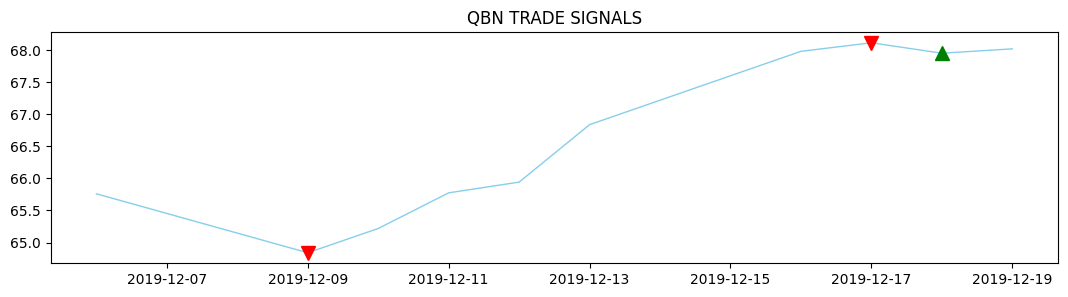

In [37]:
# plt.figure(figsize=(13,3))
# plt.plot(data0.iloc[235:245], linewidth =1, color = 'skyblue', label = 'AAPL')
# plt.plot(data0.index[235:245], BUY_PRICE, marker = '^', markersize = 10, color = 'green', label = 'BUY SIGNAL')
# plt.plot(data0.index[235:245], SELL_PRICE, marker = 'v', markersize = 10, color = 'r', label = 'SELL SIGNAL')
# plt.title('QBN TRADE SIGNALS')
# plt.show()

In [38]:
print("Signals:",np.array(all_signals))
print("States :",np.array(STATES))
print("Forecast:",new_data.iloc[-10:,-1].values)

Signals: [ 0 -1  0  0  0  0  0 -1  1  0]
States : [0 0 1 1 0 0 0 0 1 0]
Forecast: [1 1 1 0 1 0 1 1 1 0]


In [39]:
# qc.draw('mpl',fold=150)

In [42]:
all_trades = []
b_price = []
s_price = []
for i in range(1,len(STATES)):
    if STATES[i] > STATES[i-1]:
        all_trades.append(+1)
        b_price.append(data0.iloc[i+235])
        s_price.append(np.nan)
    elif STATES[i] < STATES[i-1]:
        all_trades.append(-1)
        b_price.append(np.nan)
        s_price.append(data0.iloc[i+235])
    else:
        all_trades.append(0)
        b_price.append(np.nan)
        s_price.append(np.nan)

print(np.array(all_trades))


[ 0  1  0 -1  0  0  0  1 -1]


In [41]:
STATES

[0, 0, 1, 1, 0, 0, 0, 0, 1, 0]

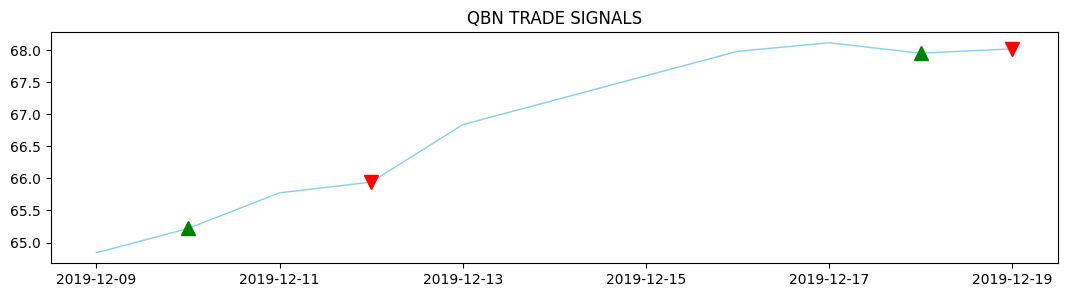

In [43]:
plt.figure(figsize=(13,3))
plt.plot(data0.iloc[236:245], linewidth =1, color = 'skyblue', label = 'AAPL')
plt.plot(data0.index[236:245], b_price, marker = '^', markersize = 10, color = 'green', label = 'BUY SIGNAL')
plt.plot(data0.index[236:245], s_price, marker = 'v', markersize = 10, color = 'r', label = 'SELL SIGNAL')
plt.title('QBN TRADE SIGNALS')
plt.show()